In [1]:
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os,glob
import cv2
import numpy as np
from os import listdir,makedirs
from os.path import isfile,join
import sys
from sklearn.model_selection import train_test_split


In [3]:
data = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
print(data.head())
final_list = []

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


In [4]:

for folder_index in range(10):
    path = 'audio_spectograms/'+str(folder_index)
    for image_file in os.listdir(path):
        #if processed_images directory exists, then save the image in that directory
        image = cv2.imread(os.path.join(path,image_file))
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray,(256,256))
        #convert image to float32
        resize = np.asarray(resize).astype(np.float32)
        #normalize the image between 0 and 1
        normalize = resize/255.0 
        #append normalize photos and their label (which is their class number) to the list
        final_list.append([normalize,int(image_file.split('-')[1])]) 

In [5]:
model = tf.keras.Sequential()
y = [i[1] for i in final_list] #labels-(class)
x = [i[0] for i in final_list] #features-(image array)
x = np.asarray(x).astype(np.float32)
y = np.array(y)

x_train,x_temp,y_train,y_temp = train_test_split(x,y,train_size = 0.8)
x_test,x_val,y_test,y_val = train_test_split(x_temp,y_temp,test_size=0.5)

model.add(tf.keras.layers.Conv2D(32,
                                 kernel_size=(3,3),strides=(1,2),
                                 padding="same",activation="relu",
                                 input_shape=(256,256,1)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(64,
                                 kernel_size=(3,3),strides=(1,2),
                                 padding="same",activation="relu"
                                 ))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64,activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64,activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10,activation="softmax"))
model.summary()

In [8]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=["Accuracy"])
results = model.fit(x_train,y_train,
                    batch_size=64,
                    epochs=20,verbose=1,
                    validation_data=(x_val,y_val))

Epoch 1/20
110/110 [==============================] - 66s 597ms/step - loss: 1.9733 - Accuracy: 0.2666 - val_loss: 1.5633 - val_Accuracy: 0.4954
Epoch 2/20
110/110 [==============================] - 66s 601ms/step - loss: 1.6391 - Accuracy: 0.3977 - val_loss: 1.2064 - val_Accuracy: 0.6648
Epoch 3/20
110/110 [==============================] - 65s 592ms/step - loss: 1.4368 - Accuracy: 0.4875 - val_loss: 1.0536 - val_Accuracy: 0.6945
Epoch 4/20
110/110 [==============================] - 68s 615ms/step - loss: 1.2921 - Accuracy: 0.5300 - val_loss: 0.9622 - val_Accuracy: 0.7048
Epoch 5/20
110/110 [==============================] - 66s 597ms/step - loss: 1.1646 - Accuracy: 0.5784 - val_loss: 0.8858 - val_Accuracy: 0.7346
Epoch 6/20
110/110 [==============================] - 66s 599ms/step - loss: 1.1067 - Accuracy: 0.6010 - val_loss: 0.7989 - val_Accuracy: 0.7506
Epoch 7/20
110/110 [==============================] - 65s 590ms/step - loss: 1.0393 - Accuracy: 0.6239 - val_loss: 0.7428 - val_Ac

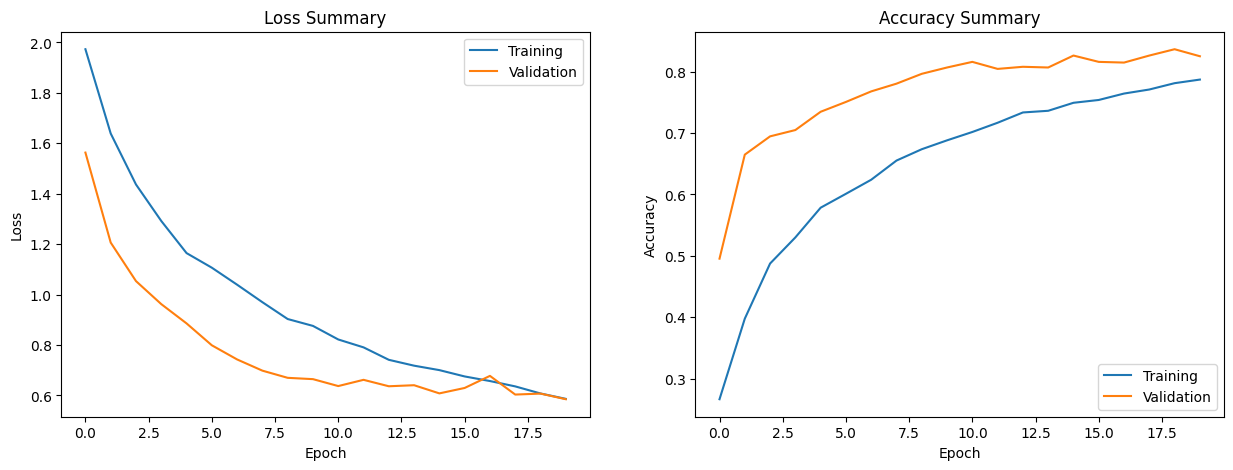

In [11]:
plt.figure(figsize=(15,5))

plt_loss = plt.subplot(121)
plt_loss.plot(results.history["loss"])
plt_loss.plot(results.history["val_loss"])
plt.title("Loss Summary")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc="upper right")

plt_accuracy = plt.subplot(122)
plt_accuracy.plot(results.history["Accuracy"])
plt_accuracy.plot(results.history["val_Accuracy"])
plt.title("Accuracy Summary")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc="lower right")